In [19]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

PATH = "/content/drive/MyDrive/ML-Olympiad/Detect-ChatGpt-answers/"

train = pd.read_csv(PATH+'data/train.csv')
test = pd.read_csv(PATH+'data/test.csv')
submission = pd.read_csv(PATH+'data/sample_submission.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. preproessing the data

In [20]:
train["text"]=train["prompt"]+train["answer"]
train=train[["text","AI"]]

In [21]:
test["text"]=test["prompt"]+test["answer"]
test=test["text"]

In [22]:
train["AI"].isna().sum()

2

In [23]:
train = train[train["AI"].isna()==False]

In [24]:
train["AI"].isna().sum()

0

In [25]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import numpy as np

In [27]:
import re
def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)
import emoji
def dataPreprocessing(x): 
    x = x.lower()
    x = removeHTML(x)
    x = emoji.demojize(x, delimiters=(" ", " "))
    x = re.sub("@\w+", '',x) # removing mentions (@)
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    x = re.sub(r"[^\w\s]", '',x) # to remove symbols
    x = re.sub("http\w+", '',x)
    x = re.sub("\s[a-z]\s", '',x)
    x = x.strip()
    return x
train_text=train["text"].apply(lambda x: dataPreprocessing(x))

In [28]:
test_text=test.apply(lambda x: dataPreprocessing(x))

## 2. import transformer to get the training vectors

In [29]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

False
cpu


In [30]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
from torch import nn
from transformers import RobertaTokenizer, RobertaModel
from transformers import AdamW
from tqdm import tqdm
class BertClassificationModel(nn.Module):
    def __init__(self,hidden_size=768,num_class=2): 
        super(BertClassificationModel, self).__init__()
        model_name = "roberta-base"
        self.tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name_or_path=model_name)
        self.bert = RobertaModel.from_pretrained(pretrained_model_name_or_path=model_name)

        for p in self.bert.parameters(): 
                p.requires_grad = False
        self.fc = nn.Linear(hidden_size, num_class)

    def forward(self, batch_sentences): 
        sentences_tokenizer = self.tokenizer(batch_sentences,
                                             truncation=True,
                                             padding=True,
                                             max_length=512,
                                             add_special_tokens=True)
        input_ids=torch.tensor(sentences_tokenizer['input_ids']).to(device) 
        attention_mask=torch.tensor(sentences_tokenizer['attention_mask']).to(device) 
        bert_out=self.bert(input_ids=input_ids,attention_mask=attention_mask) 

        last_hidden_state =bert_out[0].to(device) 
        bert_cls_hidden_state=last_hidden_state[:,0,:].to(device) 
        return bert_cls_hidden_state
model=BertClassificationModel()
model=model.to(device)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
xtrain=[]
for i in tqdm(train_text):
    xtrain.append(model([i]).cpu().detach().numpy())
xtrain=np.array(xtrain).reshape(-1,768)  
del train_text

100%|██████████| 746/746 [03:12<00:00,  3.87it/s]


In [33]:
xtest=[]
for i in tqdm(test_text):
    xtest.append(model([i]).cpu().detach().numpy())
xtest=np.array(xtest).reshape(-1,768)
del test_text

100%|██████████| 249/249 [00:52<00:00,  4.72it/s]


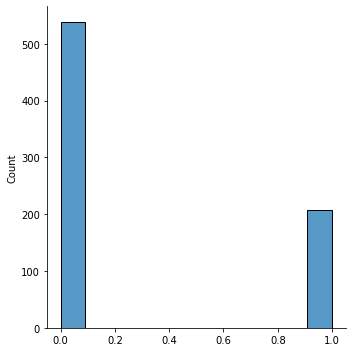

In [34]:
ytrain=train["AI"].values
import seaborn as sns
sns.displot(ytrain)

## 3. establish the capsule network

In [35]:
import torch
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def squash(x, dim=-1):
    squared_norm = (x ** 2).sum(dim=dim, keepdim=True)
    scale = squared_norm / (1 + squared_norm)
    scale=torch.tanh(squared_norm.sqrt())
    return scale * x / (squared_norm.sqrt() + 1e-8)

class PrimaryCaps1(nn.Module):
    def __init__(self, num_conv_units, in_channels, out_channels, kernel_size, stride):
        super(PrimaryCaps1, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels * num_conv_units,
                              kernel_size=kernel_size,
                              stride=stride)
        self.out_channels = out_channels

    def forward(self, x):
        out = self.conv(x)
        batch_size = out.shape[0]
        return squash(out.contiguous().view(batch_size, -1, self.out_channels), dim=-1)


class DigitCaps1(nn.Module):
    def __init__(self, in_dim, in_caps, out_caps, out_dim, num_routing):
        super(DigitCaps1, self).__init__()
        self.in_dim = in_dim
        self.in_caps = in_caps
        self.out_caps = out_caps
        self.out_dim = out_dim
        self.num_routing = num_routing
        self.device = device
        self.W = nn.Parameter(0.01 * torch.randn(1, out_caps, in_caps, out_dim, in_dim),
                              requires_grad=True)


    def forward(self, x):
        batch_size = x.size(0)
        x = x.unsqueeze(1).unsqueeze(4)
        u_hat = torch.matmul(self.W, x) 
        u_hat = u_hat.squeeze(-1) 
        temp_u_hat = u_hat.detach()
        b = torch.zeros(batch_size, self.out_caps, self.in_caps, 1).to(self.device)
        for route_iter in range(self.num_routing - 1):
            c = b.softmax(dim=1)
            s = (c * temp_u_hat).sum(dim=2)
            v = squash(s)
            uv = torch.matmul(temp_u_hat, v.unsqueeze(-1))
            b += uv
        c = b.softmax(dim=1)
        s = (c * u_hat).sum(dim=2)
        v = squash(s)

        return v
class CapsNet1(nn.Module):
    def __init__(self):
        super(CapsNet1, self).__init__()

        self.conv = nn.Conv2d(2, 256, 9)
        self.relu = nn.ReLU(inplace=True)

        self.primary_caps = PrimaryCaps1(num_conv_units=32,
                                        in_channels=256,
                                        out_channels=8,
                                        kernel_size=8,
                                        stride=2)

        self.digit_caps = DigitCaps1(in_dim=8,
                                    in_caps=160,
                                    out_caps=2,
                                    out_dim=16,
                                    num_routing=3)

        self.decoder = nn.Sequential(
            nn.Linear(16 * 2, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 768),
            nn.Softmax())

    def forward(self, x):
        #x=x.cuda()
        out = self.relu(self.conv(x))
        out = self.primary_caps(out)
        out = self.digit_caps(out)
        logits = torch.norm(out, dim=-1)
        return logits

In [36]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import os
import pickle
import random
import itertools
def get_param_group(model):
    nd_list = []
    param_list = []
    for name, param in model.named_parameters():
        if 'ln' in name:
            nd_list.append(param)
        else:
            param_list.append(param)
    return [{'params': param_list, 'weight_decay': 1e-5}, {'params': nd_list, 'weight_decay': 0}]

## 4. train

In [37]:
accs=[]
model=CapsNet1()#.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
max_f1=0
for ep in range(1200):
    correct=0
    total_loss=0
    for i in range(0, xtrain.shape[0], 1024):
        if i + 1024 > xtrain.shape[0]:
            x, y = xtrain[i:], ytrain[i:]
        else:
            x, y = xtrain[i:(i + 1024)], ytrain[i:(i + 1024)]
        x, y = Variable(torch.from_numpy(x).type(torch.FloatTensor), requires_grad=True),Variable(torch.from_numpy(y))
        
        model.train()
        x=x.reshape(-1,2,24,16)
        optimizer.zero_grad()
        logits= model(x)
        pred = torch.argmax(logits, dim=1)
        correct += pred.eq(y.data.view_as(pred)).cpu().sum()
        loss = criterion(logits, y.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if (ep + 1)%50==0:
        print('Train Epoch: {:2d}\t Loss: {:.6f}\t Accuracy: {}/{} ({:.0f}%)\n '.format(ep + 1,total_loss,correct,xtrain.shape[0],100.* correct / xtrain.shape[0]))
    accs.append(100. * correct / x.shape[0])

Train Epoch: 50	 Loss: 0.590016	 Accuracy: 539/746 (72%)
 
Train Epoch: 100	 Loss: 0.571328	 Accuracy: 539/746 (72%)
 
Train Epoch: 150	 Loss: 0.527699	 Accuracy: 539/746 (72%)
 
Train Epoch: 200	 Loss: 0.517411	 Accuracy: 539/746 (72%)
 
Train Epoch: 250	 Loss: 0.508954	 Accuracy: 545/746 (73%)
 
Train Epoch: 300	 Loss: 0.468769	 Accuracy: 653/746 (88%)
 
Train Epoch: 350	 Loss: 0.451710	 Accuracy: 659/746 (88%)
 
Train Epoch: 400	 Loss: 0.439578	 Accuracy: 668/746 (90%)
 
Train Epoch: 450	 Loss: 0.433832	 Accuracy: 678/746 (91%)
 
Train Epoch: 500	 Loss: 0.423224	 Accuracy: 684/746 (92%)
 
Train Epoch: 550	 Loss: 0.427383	 Accuracy: 684/746 (92%)
 
Train Epoch: 600	 Loss: 0.411039	 Accuracy: 697/746 (93%)
 
Train Epoch: 650	 Loss: 0.426684	 Accuracy: 689/746 (92%)
 
Train Epoch: 700	 Loss: 0.417432	 Accuracy: 703/746 (94%)
 
Train Epoch: 750	 Loss: 0.402857	 Accuracy: 707/746 (95%)
 
Train Epoch: 800	 Loss: 0.393861	 Accuracy: 709/746 (95%)
 
Train Epoch: 850	 Loss: 0.396180	 Accurac

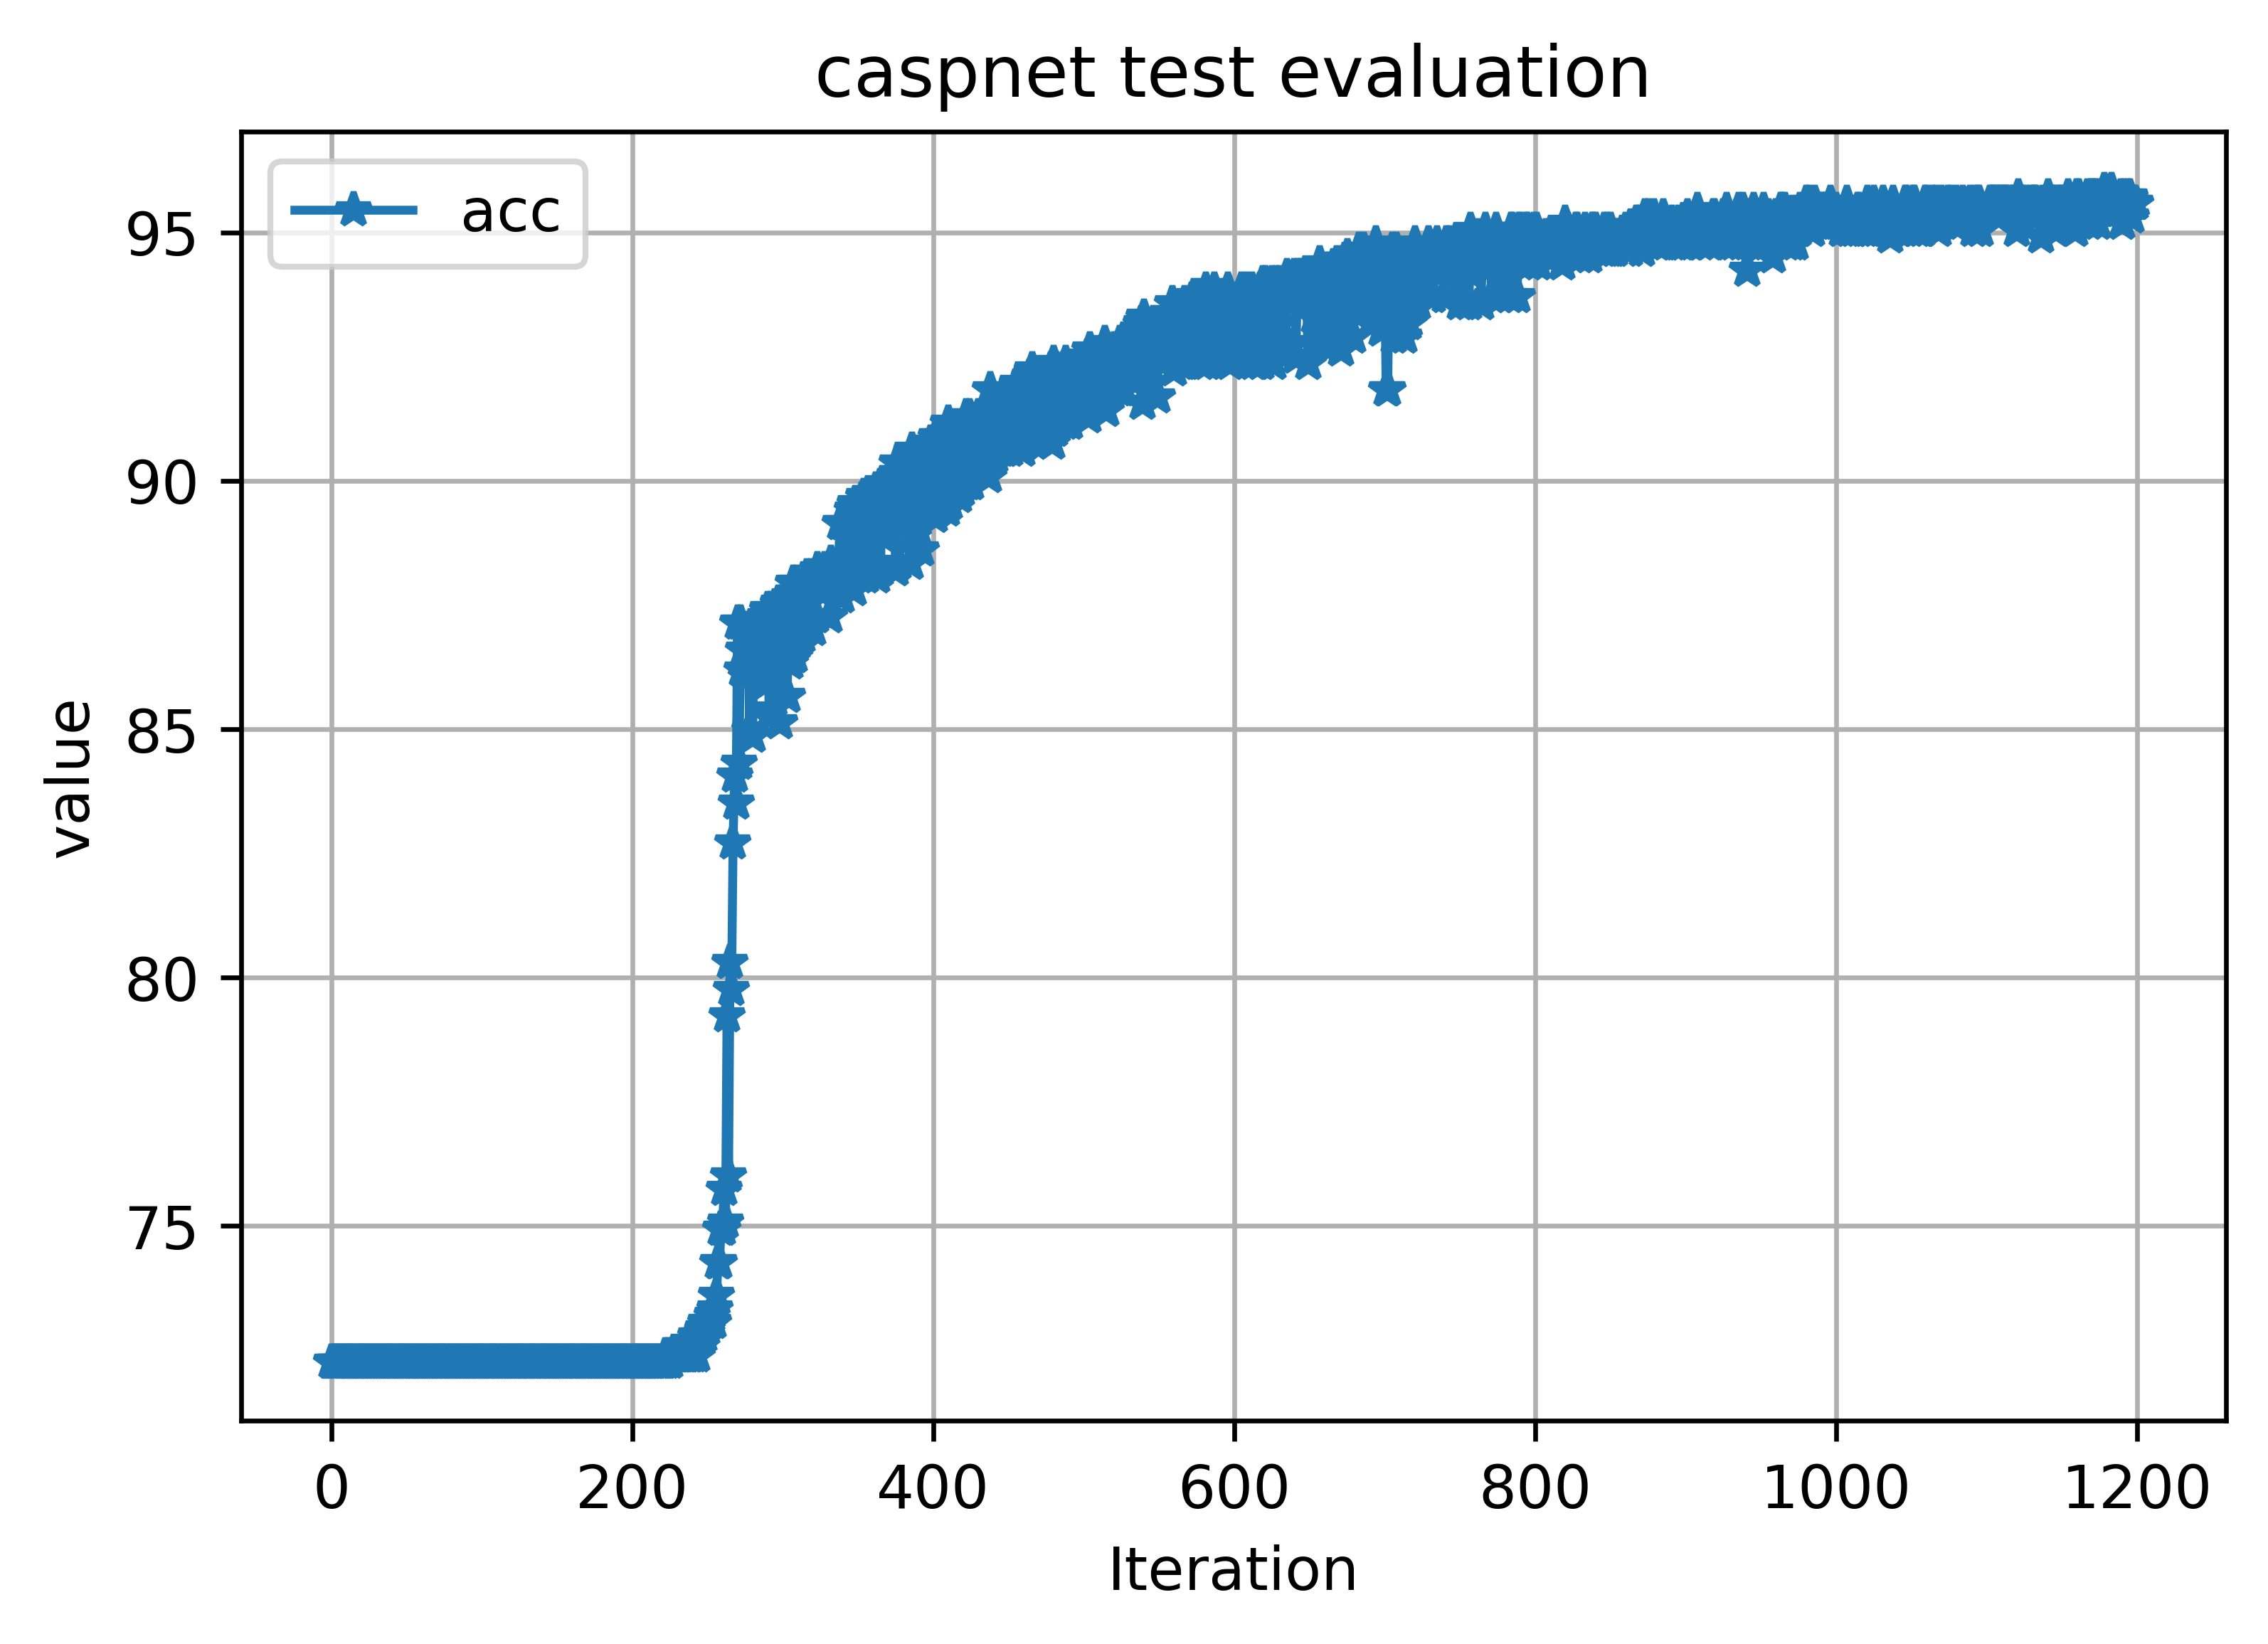

In [38]:
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei"]
plt.rcParams['axes.unicode_minus'] = False
plt.figure(dpi=600)
plt.plot(accs,'-*',label="acc")
plt.xlabel("Iteration",fontsize='medium')
plt.ylabel("value",fontsize='medium')
plt.grid()
plt.title("caspnet test evaluation")
plt.legend()
plt.show()

In [39]:
del xtrain
del x,y

## 5. predict answer

In [40]:
xtest = Variable(torch.from_numpy(xtest).type(torch.float32), requires_grad=True)

In [41]:
xtest

tensor([[-0.0243,  0.0473, -0.0182,  ..., -0.1512, -0.0718,  0.0194],
        [-0.0393,  0.0829, -0.0414,  ..., -0.1243, -0.0500, -0.0273],
        [-0.0356,  0.0931, -0.0474,  ..., -0.1285, -0.0383, -0.0255],
        ...,
        [-0.0219,  0.0922, -0.0322,  ..., -0.1165, -0.0300, -0.0478],
        [-0.0608,  0.0436, -0.0045,  ..., -0.1377, -0.0633, -0.0426],
        [-0.0583,  0.1018, -0.0233,  ..., -0.0997, -0.0131, -0.0196]],
       requires_grad=True)

In [42]:
ypred2=[]
for i in tqdm(range(xtest.shape[0])):
    ypred2.append(model(xtest[i].reshape(-1,2,24,16)).cpu().detach().numpy()[0])
ypred2=np.array(ypred2).reshape(-1,2)
ypred2

100%|██████████| 249/249 [00:02<00:00, 116.55it/s]


array([[0.81231153, 0.7275238 ],
       [0.99853545, 0.20408945],
       [0.3729328 , 0.7111563 ],
       [0.4420608 , 0.98710054],
       [0.9284077 , 0.11847983],
       [0.99044126, 0.0516627 ],
       [0.9976151 , 0.13202581],
       [0.19356534, 0.8904271 ],
       [0.93900394, 0.19291867],
       [0.92130387, 0.4487138 ],
       [0.727396  , 0.5112457 ],
       [0.3141181 , 0.8142503 ],
       [0.9939837 , 0.03755268],
       [0.9916995 , 0.03768865],
       [0.22896628, 0.913251  ],
       [0.9335573 , 0.2207516 ],
       [0.98353267, 0.26722422],
       [0.6268499 , 0.5502839 ],
       [0.81171995, 0.297522  ],
       [0.52136546, 0.67014164],
       [0.8330126 , 0.7790663 ],
       [0.9781732 , 0.08545632],
       [0.98870355, 0.22962049],
       [0.9750848 , 0.05353904],
       [0.80006474, 0.33771944],
       [0.99964744, 0.261335  ],
       [0.99531204, 0.10751315],
       [0.99052197, 0.33160707],
       [0.424459  , 0.57873297],
       [0.99789244, 0.42261824],
       [0.

In [43]:
y=np.argmax(ypred2,axis=1)

In [44]:
submission["Category"]=y
submission

,Id,Category
0,710,0
1,487,0
2,136,1
3,44,1
4,627,0
...,...,...
244,702,0
245,500,0
246,818,0
247,584,0


In [45]:
submission.to_csv(PATH+"submit/kaggle_code_submission_230226.csv",index=False)